In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
import tensorflow as tf
import os

from ssd import SSD300
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.75
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
voc_classes = ['ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
NUM_CLASSES = len(voc_classes) + 1

# from training, I pushed my weights with best validation error
weights = 'checkpoints_stratified1/weights.12-1.22.hdf5'

# path to test images
fish_path = '/home/mzhao/Desktop/kaggle/ncfm/test/unknown/'

# path where you want to save the predictions
save_path = '/home/mzhao/Desktop/kaggle/ncfm/src/ssd_keras/predictions.pkl'

In [3]:
input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)
#model.load_weights('checkpoints/weights_SSD300.hdf5', by_name=True)
model.load_weights(weights, by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)

In [4]:
sorted_names = sorted(os.listdir(fish_path))

inputs = []
images = []

for fname in sorted_names:
    if fname.endswith('.jpg'):
        img_path = os.path.join(fish_path, fname)
        img = image.load_img(img_path, target_size=(300,300))
        img = image.img_to_array(img)
        images.append(imread(img_path))
        inputs.append(img.copy())

print "Finished loading images."

inputs = preprocess_input(np.array(inputs))
print "Finished preprocessing input."

Finished loading images.
Finished preprocessing input.


In [5]:
preds = model.predict(inputs, batch_size=1, verbose=1)

 998/1000 [============================>.] - ETA: 0s

In [6]:
print preds.shape

(1000, 7308, 20)


In [7]:
# do we lose important information in this method?
results = bbox_util.detection_out(preds)

In [8]:
# this is currently the data structure I use to input
# into my submission generating ipython notebook
print len(results)
print results[0].shape

1000
(200, 6)


In [9]:
import pickle
pickle.dump(results, open(save_path,'w'), )

In [10]:
# %%time
# a = model.predict(inputs, batch_size=1)
# b = bbox_util.detection_out(preds)

In [10]:
pred = np.zeros((1000, 8))
index_map = {1:0, 2:1, 3:2, 4:3, 5:5, 6:6, 7:7}
counter = 0 
close = 0
for i, img in enumerate(images):
    
#     if counter > 100:
#         break
#     counter += 1
    
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]

    # Get detections with confidence higher than 0.6.
#     top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]
    top_indices = det_conf.copy().argsort()[-2:][::-1]
#     top_indices = np.argmax(det_conf)

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices]
#     print top_conf, top_label_indices
    pred[i][index_map[int(top_label_indices[0])]] += top_conf[0]
    if top_conf[0] <= .7:
        if top_conf[1] + .1 > top_conf[0] and top_label_indices[0] != top_label_indices[1]:
            pred[i][index_map[int(top_label_indices[1])]] += top_conf[1]
            print '{}, first: ({}, {}), second: ({}, {})'.format(i, index_map[int(top_label_indices[0])], top_conf[0],
                                                     index_map[int(top_label_indices[1])], top_conf[1])
            close += 1
print close
print pred[:10]

6, first: (7, 0.322618216276), second: (0, 0.292392164469)
10, first: (0, 0.545486569405), second: (5, 0.454027473927)
19, first: (7, 0.635851919651), second: (0, 0.537644147873)
24, first: (0, 0.377100735903), second: (2, 0.31240695715)
27, first: (5, 0.301846235991), second: (0, 0.278961569071)
28, first: (0, 0.489051043987), second: (5, 0.458175361156)
38, first: (0, 0.495850116014), second: (5, 0.479848384857)
69, first: (0, 0.393575459719), second: (2, 0.305795401335)
77, first: (7, 0.699524343014), second: (0, 0.651296377182)
96, first: (0, 0.422127515078), second: (2, 0.404422402382)
113, first: (0, 0.264095127583), second: (2, 0.234348669648)
121, first: (2, 0.555961489677), second: (0, 0.466365218163)
122, first: (1, 0.365525007248), second: (0, 0.308469206095)
142, first: (0, 0.478451997042), second: (5, 0.465398907661)
143, first: (7, 0.465276002884), second: (0, 0.44835844636)
159, first: (0, 0.472446858883), second: (7, 0.42551651597)
170, first: (0, 0.50232565403), second

In [11]:
vgg_pred = np.load("/home/mzhao/Desktop/kaggle/ncfm/pred/pred_vgg16_all_10epochs_relabeled.npy")

In [12]:
nof = 0
for i in range(1000):
    if np.argmax(vgg_pred[i]) == 4 and max(pred[i]) < .7:
        pred[i] /= sum(pred[i])
        pred[i] *= (1 - vgg_pred[i][4])
        pred[i][4] += vgg_pred[i][4]
#         print sum(pred[i])
        nof += 1
    else:
        pred[i] /= sum(pred[i])
print "nof", nof

nof 122


In [13]:
other = 0
for i in range(1000):
    if np.argmax(pred[i]) == 5:
        other += 1
print "other", other

other 28


In [14]:
print np.sum(pred, axis=0)

[ 628.41358565   20.07528296   21.40532283   32.69690993  109.06509327
   29.64592841    5.00765687  153.69022008]


In [15]:
preds = np.clip(pred, 0.02, .98, out=None)

sorted_names = sorted(os.listdir(fish_path))
with open('/home/mzhao/Desktop/kaggle/ncfm/submissions/ssd_base3.csv', 'w') as f:
    print("Writing Predictions to CSV...")
    f.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
    for i, image_name in enumerate(sorted_names):
        pred = ['%.6f' % (p/np.sum(preds[i, :])) for p in preds[i, :]]
        f.write('%s,%s\n' % (os.path.basename(image_name), ','.join(pred)))
    print("Done.")

Writing Predictions to CSV...
Done.


In [36]:
counter = 0 
for i, img in enumerate(images):
#     print sorted_names[i]
    
#     if counter > 100:
#         break
#     counter += 1
    
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
#     top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]
    top_indices = det_conf.copy().argsort()[-2:][::-1]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    path_in = "../../test/unknown/{}".format(sorted_names[i])
#     path_out = "../../test_cropped/unknown/{}".format(sorted_names[i])
    path_out = "../../test_sq_crop/unknown/{}".format(sorted_names[i])
    img = cv2.imread(path_in)
    y1 = top_ymin[0]*img.shape[0]
    y2 = top_ymax[0]*img.shape[0]
    x1 = top_xmin[0]*img.shape[1]
    x2 = top_xmax[0]*img.shape[1]
    ydif = y2 - y1
    y1 = max(0, y1-.1*ydif)
    y2 = min(img.shape[0], y2+.1*ydif)
    xdif = x2 - x1
    x1 = max(0, x1-.1*xdif)
    x2 = min(img.shape[1], x2+.1*xdif)
#     print y1,y2,x1,x2
    img = img[int(y1):int(y2),int(x1):int(x2)]
#     img = cv2.resize(img, (224,224), cv2.INTER_LINEAR)
#     print img.shape
    cv2.imwrite(path_out,img)
#     plt.imshow(img)
#     plt.show()
    

img_00005.jpg
0


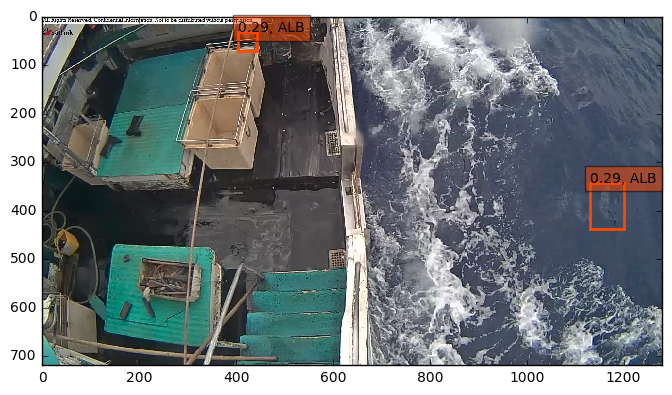

img_00007.jpg
1


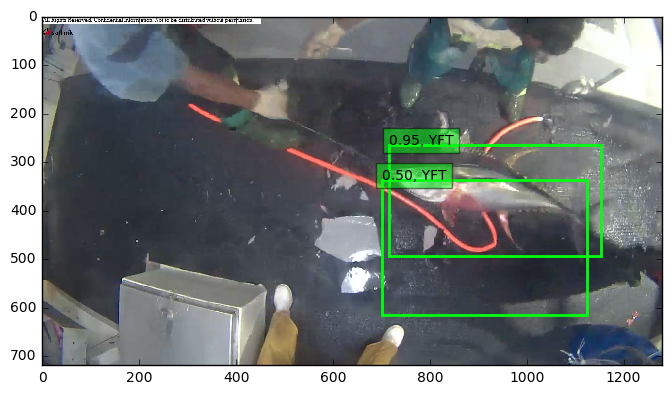

img_00009.jpg
2


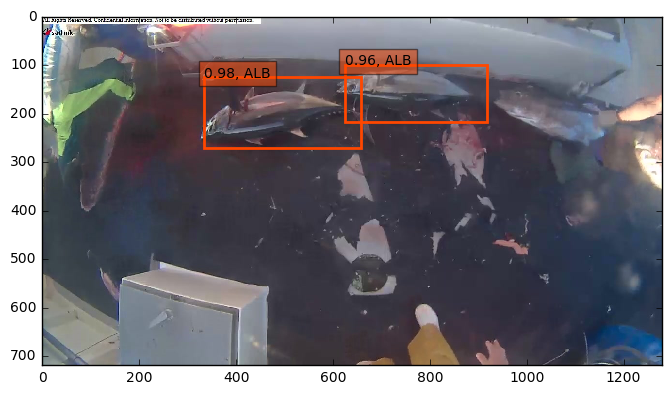

img_00018.jpg
3


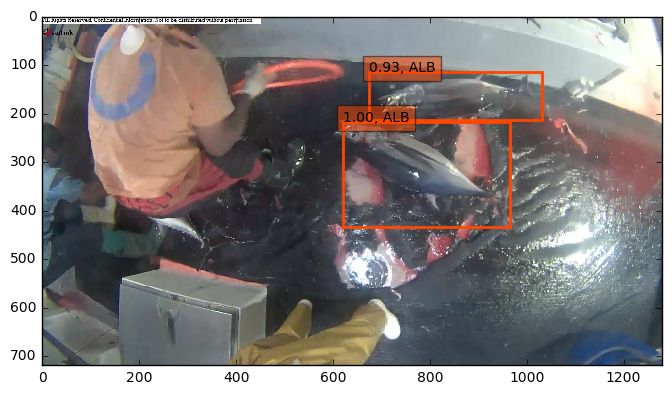

img_00027.jpg
4


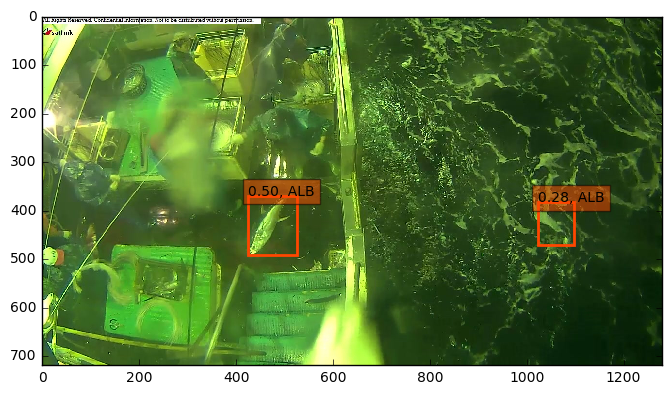

img_00030.jpg
5


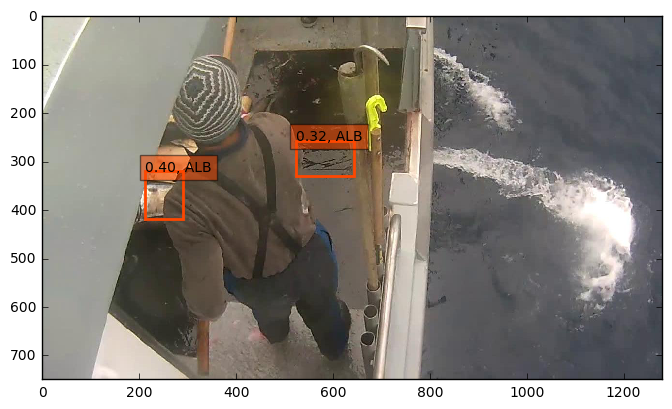

img_00040.jpg
6


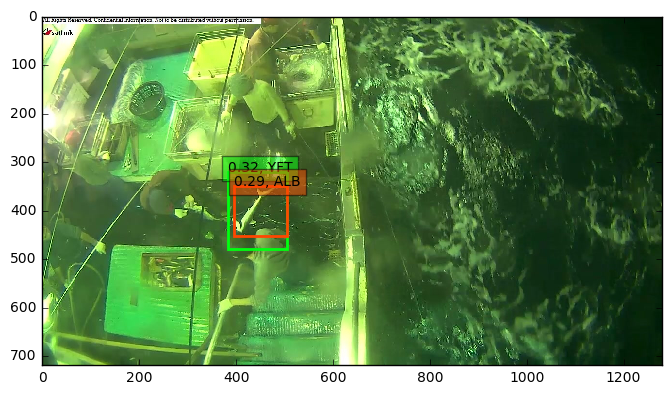

img_00046.jpg
7


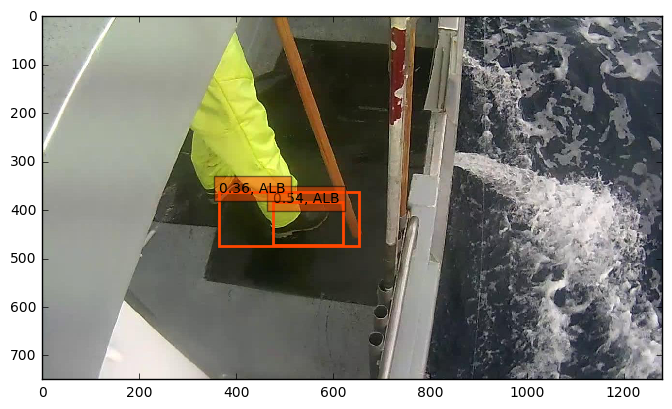

img_00053.jpg
8


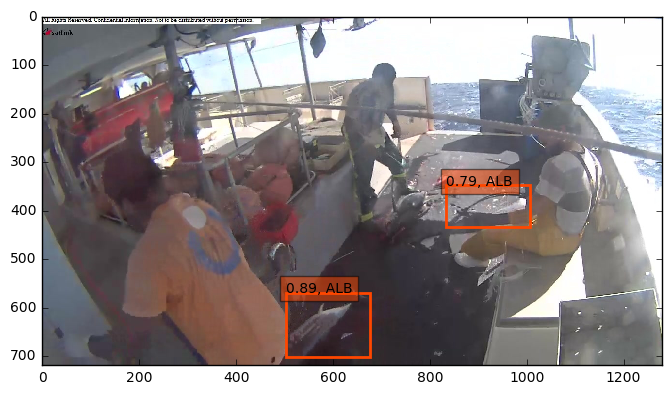

img_00071.jpg
9


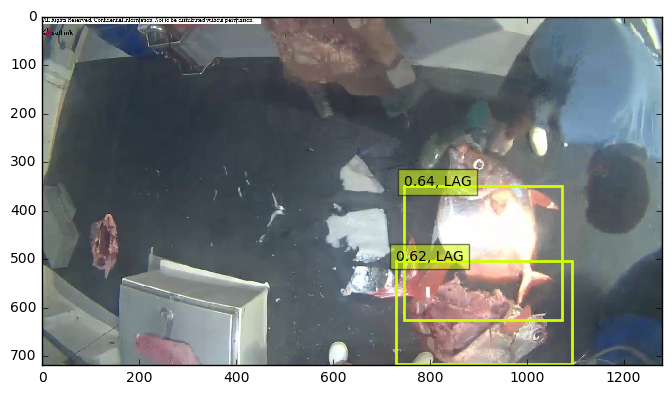

img_00075.jpg
10


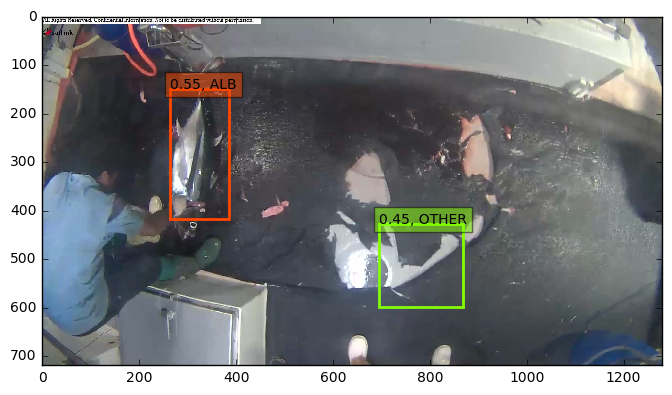

img_00102.jpg


In [35]:
counter = 0 
for i, img in enumerate(images):
    print sorted_names[i]
    
    if counter > 10:
        break
    counter += 1
    
    print i
    
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
#     top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]
    top_indices = det_conf.copy().argsort()[-2:][::-1]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()